# Contrastive Learning

## 1. Czym jest Contrastive Learning?

**Contrastive Learning** uczy sieć neuronową tworzyć reprezentacje (embeddingi), gdzie:
- **Podobne** przykłady są blisko siebie
- **Różne** przykłady są daleko od siebie

### Kluczowe pojęcia

| Pojęcie | Opis |
|---------|------|
| **Anchor** | Główna próbka |
| **Positive** | Próbka podobna do anchora (ta sama klasa) |
| **Negative** | Próbka różna od anchora (inna klasa) |

### Triplet Loss

$$L = \max(d(a, p) - d(a, n) + \text{margin}, 0)$$

Cel: odległość anchor-negative powinna być większa niż anchor-positive o co najmniej `margin`.

## 2. Instalacja i import

instalacja pakietów: `pip install -r requirements.txt`

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np

# pytorch-metric-learning - gotowe funkcje straty i minery
from pytorch_metric_learning import losses, miners
from pytorch_metric_learning.distances import CosineSimilarity

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Używam: {device}")

Używam: cuda


## 3. Dane - CIFAR-10

Użyjemy CIFAR-10 (10 klas obrazów 32x32) do demonstracji.

In [2]:
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Pobierz dane (tylko train, mały subset dla szybkości)
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

# Używamy tylko 5000 próbek dla szybszego treningu
trainset = torch.utils.data.Subset(trainset, range(5000))
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(f"Liczba próbek: {len(trainset)}")

100%|██████████| 170M/170M [02:54<00:00, 979kB/s]  


Liczba próbek: 5000


/home/vantom/Col/AIPO/proj/venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


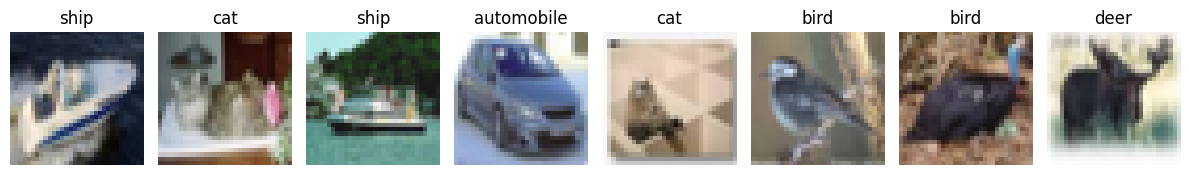

In [3]:
# Podgląd przykładowych obrazów
def show_images(loader, n=8):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, n, figsize=(12, 2))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy() * 0.5 + 0.5  # denormalize
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_images(trainloader)

## 4. Model - Prosty Encoder

Sieć konwolucyjna, która przekształca obrazy w wektory (embeddingi).

In [4]:
class EmbeddingNet(nn.Module):
    """Prosty encoder CNN -> embedding"""
    
    def __init__(self, embedding_dim=64):
        super().__init__()
        
        # Konwolucje
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1)
        )
        
        # Projekcja do przestrzeni embeddingów
        self.fc = nn.Linear(128, embedding_dim)
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        # Normalizacja L2 - ważne dla contrastive learning!
        x = nn.functional.normalize(x, p=2, dim=1)
        return x

model = EmbeddingNet(embedding_dim=64).to(device)
print(f"Parametry modelu: {sum(p.numel() for p in model.parameters()):,}")

Parametry modelu: 101,504


## 5. Trening z pytorch-metric-learning

Używamy:
- **TripletMarginLoss** - gotowa implementacja Triplet Loss
- **TripletMarginMiner** - automatycznie wybiera trudne triplety

### Szczegóły implementacji w bibliotece

**TripletMarginLoss:**
- Domyślnie używa odległości L2 (euklidesowej) z normalizacją embeddingów
- Parametr `margin` (domyślnie 0.05) określa minimalną różnicę między d(a,p) i d(a,n)

**TripletMarginMiner:**
- `type_of_triplets="hard"` - wybiera triplety gdzie negatyw jest bliżej anchora niż pozytyw
- `type_of_triplets="semihard"` - negatyw dalej niż pozytyw, ale wciąż narusza margines
- `type_of_triplets="all"` - wszystkie triplety naruszające margines

In [5]:
# Funkcja straty - Triplet Margin Loss
# margin=0.2 (większy niż domyślny 0.05, bo chcemy większą separację)
loss_fn = losses.TripletMarginLoss(margin=0.2)

# Miner - automatycznie znajduje trudne triplety w batchu
# Używamy tego samego marginu co w loss dla spójności
# "hard" = najtrudniejsze przypadki (negatyw bliżej anchora niż pozytyw)
miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="hard")

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [6]:
def train_epoch(model, loader, loss_fn, miner, optimizer):
    model.train()
    total_loss = 0
    total_triplets = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        # Forward
        embeddings = model(images)
        
        # Miner znajduje triplety
        hard_pairs = miner(embeddings, labels)
        
        # Oblicz stratę
        loss = loss_fn(embeddings, labels, hard_pairs)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_triplets += miner.num_triplets
    
    return total_loss / len(loader), total_triplets

In [7]:
# Trening
epochs = 10
history = []

print("Rozpoczynam trening...")
for epoch in range(epochs):
    loss, triplets = train_epoch(model, trainloader, loss_fn, miner, optimizer)
    history.append(loss)
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss:.4f} | Triplets: {triplets}")

print("Trening zakończony!")

Rozpoczynam trening...
Epoch 1/10 | Loss: 0.2038 | Triplets: 635931
Epoch 2/10 | Loss: 0.2003 | Triplets: 624342
Epoch 3/10 | Loss: 0.1977 | Triplets: 645978
Epoch 4/10 | Loss: 0.2001 | Triplets: 640392
Epoch 5/10 | Loss: 0.2001 | Triplets: 631868
Epoch 6/10 | Loss: 0.1976 | Triplets: 631894
Epoch 7/10 | Loss: 0.2001 | Triplets: 615614
Epoch 8/10 | Loss: 0.2001 | Triplets: 615054
Epoch 9/10 | Loss: 0.1976 | Triplets: 607498
Epoch 10/10 | Loss: 0.2001 | Triplets: 594120
Trening zakończony!


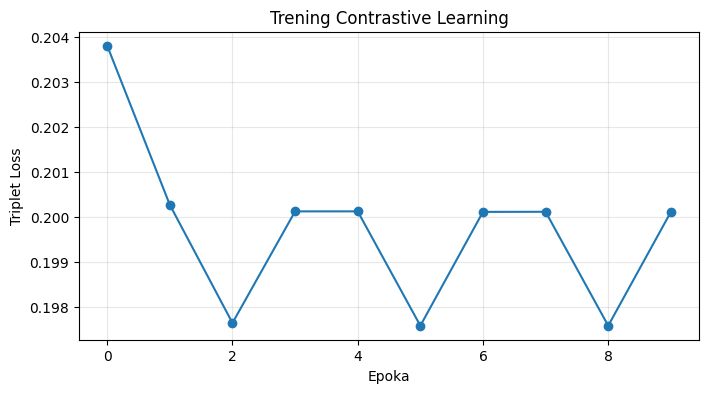

In [8]:
# Wykres straty
plt.figure(figsize=(8, 4))
plt.plot(history, marker='o')
plt.xlabel('Epoka')
plt.ylabel('Triplet Loss')
plt.title('Trening Contrastive Learning')
plt.grid(True, alpha=0.3)
plt.show()

## 6. Wizualizacja embeddingów

Użyjemy t-SNE do redukcji wymiarów i zobaczenia czy klasy się separują.

In [9]:
from sklearn.manifold import TSNE

@torch.no_grad()
def get_embeddings(model, loader, n_samples=1000):
    """Pobierz embeddingi dla próbek"""
    model.eval()
    embeddings = []
    labels = []
    
    for images, batch_labels in loader:
        images = images.to(device)
        emb = model(images)
        embeddings.append(emb.cpu())
        labels.append(batch_labels)
        
        if sum(len(e) for e in embeddings) >= n_samples:
            break
    
    return torch.cat(embeddings)[:n_samples], torch.cat(labels)[:n_samples]

embeddings, labels = get_embeddings(model, trainloader, n_samples=1000)
print(f"Zebrano {len(embeddings)} embeddingów")

Zebrano 1000 embeddingów


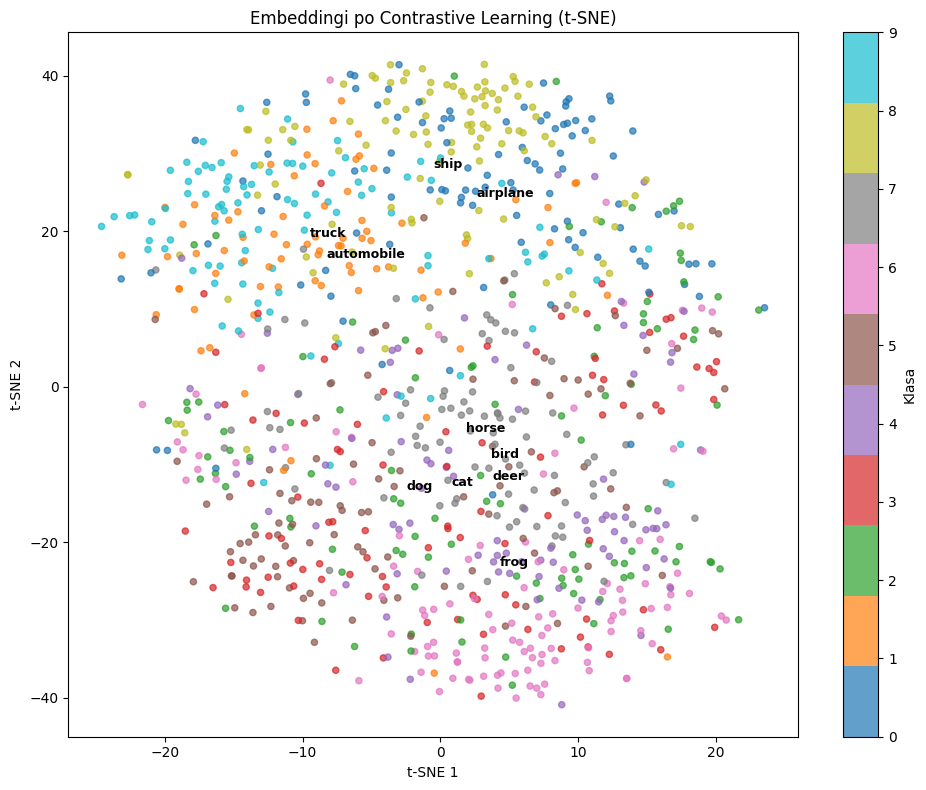

In [10]:
# t-SNE redukcja do 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings.numpy())

# Wizualizacja
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    embeddings_2d[:, 0], embeddings_2d[:, 1],
    c=labels.numpy(), cmap='tab10', s=20, alpha=0.7
)
plt.colorbar(scatter, ticks=range(10), label='Klasa')
plt.title('Embeddingi po Contrastive Learning (t-SNE)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')

# Legenda
for i, name in enumerate(classes):
    mask = labels.numpy() == i
    if mask.any():
        plt.annotate(name, embeddings_2d[mask].mean(axis=0), fontsize=9, weight='bold')

plt.tight_layout()
plt.show()

## 7. Wyszukiwanie podobnych obrazów (Retrieval)

Praktyczne zastosowanie - znajdowanie podobnych obrazów.

In [11]:
@torch.no_grad()
def find_similar(model, query_img, embeddings_db, images_db, k=5):
    """Znajdź k najbardziej podobnych obrazów"""
    model.eval()
    
    # Embedding zapytania
    query_emb = model(query_img.unsqueeze(0).to(device))
    
    # Podobieństwo cosinusowe do wszystkich
    similarities = torch.mm(query_emb, embeddings_db.T).squeeze()
    
    # Top-k
    top_k = similarities.topk(k)
    return top_k.indices, top_k.values

In [12]:
# Przygotuj bazę danych embeddingów
test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)
test_loader = DataLoader(test_set, batch_size=100, shuffle=False)

# Zbierz embeddingi i obrazy
db_embeddings, db_labels = get_embeddings(model, test_loader, n_samples=1000)

# Zbierz też surowe obrazy do wyświetlenia
db_images = []
for img, _ in torch.utils.data.Subset(test_set, range(1000)):
    db_images.append(img)
db_images = torch.stack(db_images)

/home/vantom/Col/AIPO/proj/venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


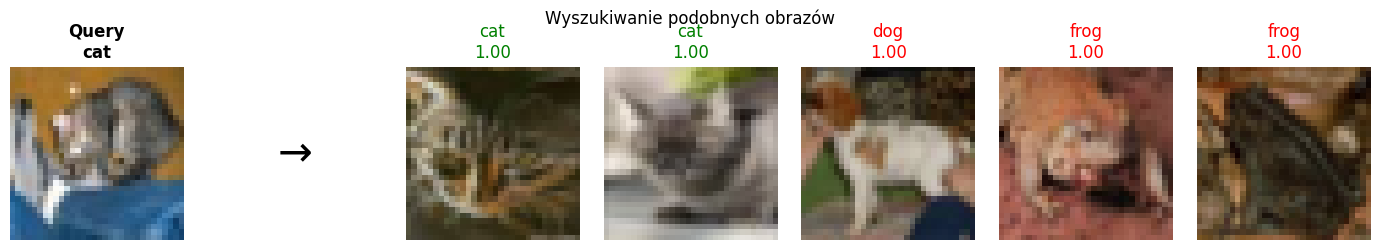

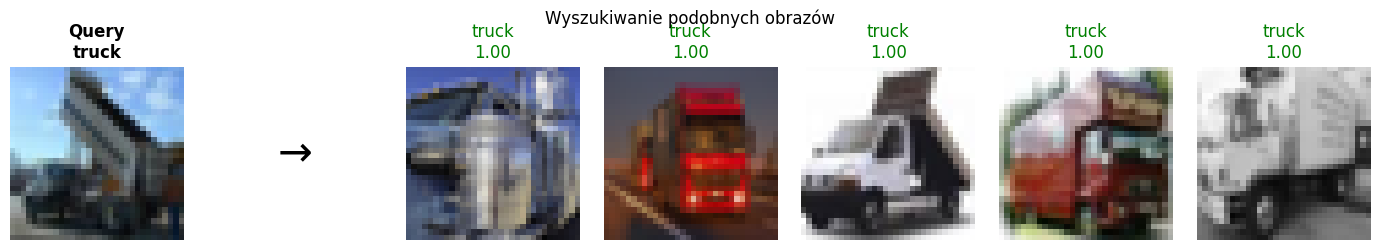

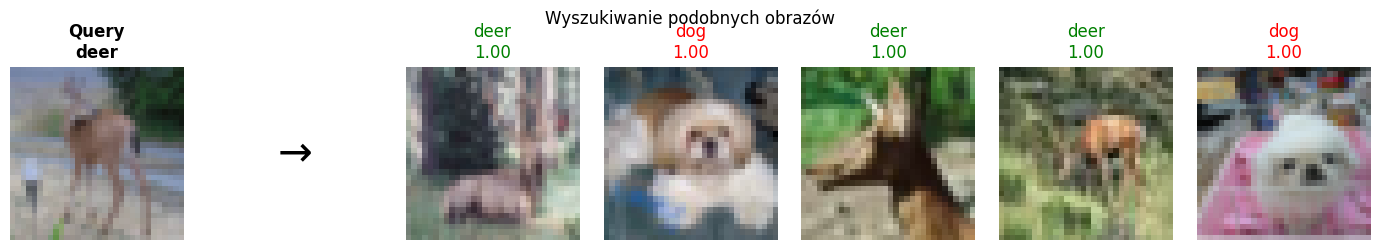

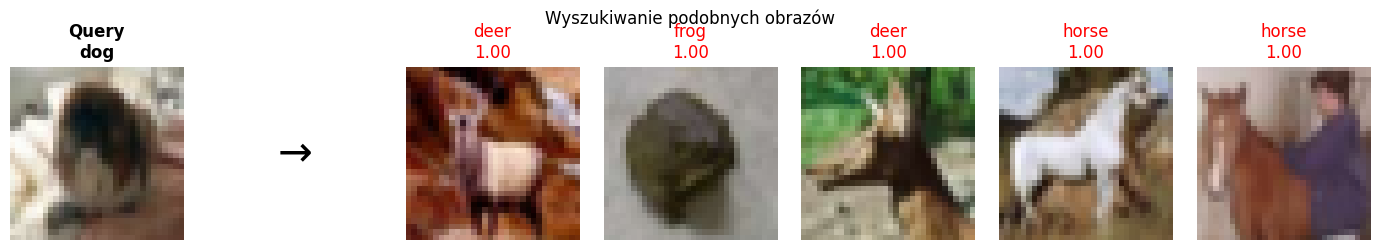

In [13]:
def show_retrieval(query_idx, k=5):
    """Pokaż wyniki wyszukiwania"""
    query_img = db_images[query_idx]
    query_label = db_labels[query_idx].item()
    
    # Znajdź podobne (pomijamy sam query)
    indices, scores = find_similar(model, query_img, db_embeddings.to(device), db_images, k=k+1)
    
    # Wizualizacja
    fig, axes = plt.subplots(1, k+2, figsize=(14, 2.5))
    
    # Query
    img = query_img.permute(1, 2, 0).numpy() * 0.5 + 0.5
    axes[0].imshow(img)
    axes[0].set_title(f'Query\n{classes[query_label]}', fontweight='bold')
    axes[0].axis('off')
    
    # Separator
    axes[1].text(0.5, 0.5, '→', fontsize=30, ha='center', va='center')
    axes[1].axis('off')
    
    # Wyniki
    result_idx = 0
    for i, (idx, score) in enumerate(zip(indices, scores)):
        if idx == query_idx:  # pomiń sam query
            continue
        if result_idx >= k:
            break
            
        img = db_images[idx].permute(1, 2, 0).numpy() * 0.5 + 0.5
        result_label = db_labels[idx].item()
        
        axes[result_idx + 2].imshow(img)
        color = 'green' if result_label == query_label else 'red'
        axes[result_idx + 2].set_title(
            f'{classes[result_label]}\n{score:.2f}', 
            color=color
        )
        axes[result_idx + 2].axis('off')
        result_idx += 1
    
    plt.suptitle('Wyszukiwanie podobnych obrazów', fontsize=12)
    plt.tight_layout()
    plt.show()

# Przykłady wyszukiwania
for query_idx in [0, 50, 100, 200]:
    show_retrieval(query_idx, k=5)

## 8. Inne funkcje straty (pytorch-metric-learning)

Biblioteka oferuje wiele gotowych implementacji:

In [14]:
# Przykłady innych funkcji straty dostępnych w pytorch-metric-learning:

# 1. Contrastive Loss - klasyczne podejście parami (positive/negative)
contrastive = losses.ContrastiveLoss(pos_margin=0, neg_margin=1)

# 2. NTXentLoss - używane w SimCLR (self-supervised)
# temperature: MoCo używa 0.07, SimCLR używa 0.5
# Domyślnie używa CosineSimilarity jako metryki
ntxent = losses.NTXentLoss(temperature=0.07)

# 3. ArcFace - popularne w face recognition
# Wymaga podania liczby klas i rozmiaru embeddingu
arcface = losses.ArcFaceLoss(num_classes=10, embedding_size=64)

# 4. MultiSimilarityLoss - zaawansowane, często lepsze wyniki
multi_sim = losses.MultiSimilarityLoss(alpha=2, beta=50, base=0.5)

print("Dostępne funkcje straty w pytorch-metric-learning:")
print("- TripletMarginLoss (domyślnie L2 distance)")
print("- ContrastiveLoss (pary positive/negative)")
print("- NTXentLoss (SimCLR, używa cosine similarity)")
print("- ArcFaceLoss (wymaga num_classes)")
print("- MultiSimilarityLoss")
print("- ... i wiele innych!")

Dostępne funkcje straty w pytorch-metric-learning:
- TripletMarginLoss (domyślnie L2 distance)
- ContrastiveLoss (pary positive/negative)
- NTXentLoss (SimCLR, używa cosine similarity)
- ArcFaceLoss (wymaga num_classes)
- MultiSimilarityLoss
- ... i wiele innych!


### Kluczowe korzyści biblioteki PyTorch:

1. **Hard mining** - automatyczne znajdowanie trudnych tripletów
2. **Wiele funkcji straty** - TripletLoss, NTXent, ArcFace, itp.
3. **Integracja z PyTorch** - działa z DataLoader, GPU, itp.
4. **Gotowe metryki** - ewaluacja retrieval, accuracy, itp.


## 10. Zadania

### Zadanie 1: Przetestuj inną funkcję straty
Zamień `TripletMarginLoss` na `NTXentLoss` i porównaj wyniki.

In [ ]:
# TODO: Użyj NTXentLoss zamiast TripletMarginLoss
# ntxent_loss = losses.NTXentLoss(temperature=0.07)
# ... trening ...

### Zadanie 2: Augmentacje jako positive examples
Dodaj augmentacje (rotacja, flip, color jitter) i traktuj zeminione wersje jako positive.

In [ ]:
# TODO: Zdefiniuj transformacje augmentacji
# augment = T.Compose([
#     T.RandomHorizontalFlip(),
#     T.RandomRotation(15),
#     T.ColorJitter(brightness=0.2, contrast=0.2),
# ])